In [1]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
# *** Modification ***
from arcFace import ArcFaceClient # Import the new model class
from scipy.spatial.distance import cosine # To calculate similarity

In [2]:
# Load YOLOv8 for face detection
model_yolo = YOLO('YoloV8 Face.pt')

# Load the ArcFace model for generating embeddings
# *** Modification ***
arcface_model = ArcFaceClient()
model_embedding = arcface_model.model # This is the loaded ArcFace model

# Load the CSV file created in the first part
csv_path = 'Face Recognition.csv'
df = pd.read_csv(csv_path)

print("Models and CSV data loaded successfully.")

Models and CSV data loaded successfully.


In [3]:
# Get all column names except the 'Name' column
embedding_columns = df.columns.tolist()
embedding_columns.remove('Name')

# Convert the embedding columns to a numpy array
# These are the "known" embeddings
known_embeddings = df[embedding_columns].values

# Get the corresponding names
known_names = df['Name'].values

print(f"Loaded {len(known_names)} known embeddings.")

Loaded 355 known embeddings.


In [4]:
def findCosineSimilarity(source_embedding, test_embedding):
    """
    Calculates the cosine similarity between two embedding vectors.
    """
    # The cosine function from scipy calculates the *distance* (1 - similarity)
    # A smaller distance means a better match.
    distance = cosine(source_embedding, test_embedding)
    return distance

In [ ]:
# Open the webcam
cap = cv2.VideoCapture(0) 

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # 1. Detect faces using YOLO
    results = model_yolo(frame, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for box in boxes:
        x1, y1, x2, y2 = box
        
        # 2. Crop the face
        face_img = frame[y1:y2, x1:x2]
        
        # 3. Pre-process the face for ArcFace
        face_img = cv2.resize(face_img, (112, 112)) # Resize to ArcFace input size
        face_img = face_img.astype(np.float32)
        face_array = np.expand_dims(face_img, axis=0) # Make it (1, 112, 112, 3)

        # 4. Get the embedding for the live face
        live_embedding = model_embedding.predict(face_array, verbose=False)[0, :]
        
        min_sim = 1.0 # Initialize with max distance
        min_sim_idx = -1
        
        # 5. Compare with all known embeddings
        for i in range(len(known_embeddings)):
            known_emb = known_embeddings[i]
            sim = findCosineSimilarity(live_embedding, known_emb)
            
            if sim < min_sim:
                min_sim = sim
                min_sim_idx = i
        
        # 6. Decide if the person is known or unknown
        # *** IMPORTANT: You MUST tune this threshold ***
        # VGG-Face used ~0.25, ArcFace needs a different value.
        # Start with 0.5 and see if it works.
        # Lower value = stricter match.
        recognition_threshold = 0.3
        
        if min_sim < recognition_threshold:
            final_name = known_names[min_sim_idx]
            color = (0, 255, 0) # Green for known
        else:
            final_name = "Unknown"
            color = (0, 0, 255) # Red for unknown
            
        # 7. Draw the box and name on the original frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{final_name} ({min_sim:.2f})", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the final frame
    cv2.imshow('Live Face Recognition', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

Result image saved to: output_image.jpg


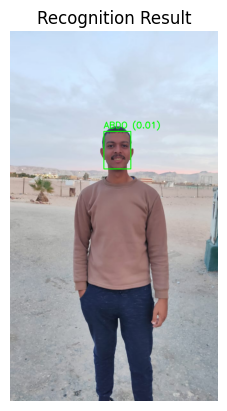

In [12]:
import matplotlib.pyplot as plt

# --- Modify these names ---
INPUT_IMAGE_PATH = "D:\my data\عبده جيش\IMG-20241206-WA0013.jpg" # The image you want to test
OUTPUT_IMAGE_PATH = 'output_image.jpg' # The name of the resulting image
recognition_threshold = 0.3 # Use the same threshold as in the live code
# -------------------------

# 1. Load the image
frame = cv2.imread(INPUT_IMAGE_PATH)

if frame is None:
    print(f"Error: Could not read image from {INPUT_IMAGE_PATH}")
else:
    # 2. Detect faces
    results = model_yolo(frame, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for box in boxes:
        x1, y1, x2, y2 = box
        
        # 3. Crop and pre-process the face
        face_img = frame[y1:y2, x1:x2]
        face_img = cv2.resize(face_img, (112, 112))
        face_img = face_img.astype(np.float32)
        face_array = np.expand_dims(face_img, axis=0)

        # 4. Calculate the embedding
        live_embedding = model_embedding.predict(face_array, verbose=False)[0, :]
        
        min_sim = 1.0 # Initialize with max distance
        min_sim_idx = -1
        
        # 5. Compare with all known embeddings
        for i in range(len(known_embeddings)):
            known_emb = known_embeddings[i]
            sim = findCosineSimilarity(live_embedding, known_emb)
            
            if sim < min_sim:
                min_sim = sim
                min_sim_idx = i
        
        # 6. Determine the name
        if min_sim < recognition_threshold:
            final_name = known_names[min_sim_idx]
            color = (0, 255, 0) # Green
        else:
            final_name = "Unknown"
            color = (0, 0, 255) # Red
            
        # 7. Draw the box and name
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{final_name} ({min_sim:.2f})", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # 8. Save and display the result
    cv2.imwrite(OUTPUT_IMAGE_PATH, frame)
    print(f"Result image saved to: {OUTPUT_IMAGE_PATH}")
    
    # Display the image in the notebook (converting BGR to RGB)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Recognition Result")
    plt.axis('off')
    plt.show()

In [ ]:
from IPython.display import Video # To display the video at the end

# --- Modify these names ---
INPUT_VIDEO_PATH = 'my_test_video.mp4' # The video you want to test
OUTPUT_VIDEO_PATH = 'output_video.mp4' # The name of the resulting video
recognition_threshold = 0.3 # Use the same threshold as in the live code
# -------------------------

cap = cv2.VideoCapture(INPUT_VIDEO_PATH)

# Get video properties for the VideoWriter
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for the video
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))

print(f"Processing video: {INPUT_VIDEO_PATH}...")

while True:
    ret, frame = cap.read()
    if not ret:
        break # Video has ended

    # 1. Detect faces
    results = model_yolo(frame, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    for box in boxes:
        x1, y1, x2, y2 = box
        
        # 2. Crop and pre-process the face
        face_img = frame[y1:y2, x1:x2]
        if face_img.size == 0: continue # Skip empty faces
            
        face_img = cv2.resize(face_img, (112, 112))
        face_img = face_img.astype(np.float32)
        face_array = np.expand_dims(face_img, axis=0)

        # 3. Calculate the embedding
        live_embedding = model_embedding.predict(face_array, verbose=False)[0, :]
        
        min_sim = 1.0
        min_sim_idx = -1
        
        # 4. Compare
        for i in range(len(known_embeddings)):
            known_emb = known_embeddings[i]
            sim = findCosineSimilarity(live_embedding, known_emb)
            
            if sim < min_sim:
                min_sim = sim
                min_sim_idx = i
        
        # 5. Determine the name
        if min_sim < recognition_threshold:
            final_name = known_names[min_sim_idx]
            color = (0, 255, 0) # Green
        else:
            final_name = "Unknown"
            color = (0, 0, 255) # Red
            
        # 6. Draw the box and name
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"{final_name} ({min_sim:.2f})", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # 7. Write the processed frame to the new video file
    out.write(frame)

# 8. Release all resources
cap.release()
out.release()
print(f"Finished! New video saved to: {OUTPUT_VIDEO_PATH}")

# 9. Display the output video (works in Colab/Jupyter)
Video(OUTPUT_VIDEO_PATH)

جاري معالجة الفيديو: D:\BCAI_4\C_V\SEC\Face_Detection_Recognition\ABDO.mp4...
تم الانتهاء! الفيديو الجديد محفوظ في: output_video.mp4
